In [7]:
!nvidia-smi


Mon Dec 15 08:06:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [27]:
# Install required packages
%pip install torch torchvision tqdm matplotlib -q


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


# Diffusion Model Implementation

## 1. Noise Schedule


In [29]:
# Noise schedule parameters
T = 1000  # Number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_bar = torch.cumprod(alphas, dim=0)

print(f"Beta range: {betas[0]:.6f} to {betas[-1]:.6f}")
print(f"Alpha_bar range: {alpha_bar[0]:.6f} to {alpha_bar[-1]:.6f}")


Beta range: 0.000100 to 0.020000
Alpha_bar range: 0.999900 to 0.000040


## 2. Forward Diffusion Process


In [30]:
def q_sample(x0, t, noise=None):
    """
    Forward diffusion: add noise to image x0 at timestep t
    
    Args:
        x0: Original image [batch, channels, height, width]
        t: Timestep indices [batch]
        noise: Optional noise tensor (if None, generates new noise)
    
    Returns:
        Noisy image x_t
    """
    if noise is None:
        noise = torch.randn_like(x0)
    
    # Get alpha_bar values for each sample in batch
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    
    # x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * epsilon
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise


## 3. U-Net Model Architecture


In [35]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


class SimpleUNet(nn.Module):
    """
    Simple U-Net for noise prediction
    Input: noisy image x_t and timestep t
    Output: predicted noise epsilon
    """
    def __init__(self, c_in=1, c_out=1, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )
        
        # Encoder (downsampling)
        self.down1 = self._make_layer(c_in, 64)
        self.down2 = self._make_layer(64, 128)
        self.down3 = self._make_layer(128, 256)
        
        # Bottleneck
        self.bottleneck = self._make_layer(256, 512)
        
        # Decoder (upsampling)
        self.up1 = self._make_layer(512 + 256, 256)
        self.up2 = self._make_layer(256 + 128, 128)
        self.up3 = self._make_layer(128 + 64, 64)
        
        # Output
        self.out = nn.Conv2d(64 + time_dim, c_out, 1)
        
        self.pool = nn.MaxPool2d(2)
    
    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def _upsample_and_match(self, x, target_size):
        """Upsample x to match target_size exactly"""
        return F.interpolate(x, size=target_size, mode='bilinear', align_corners=True)
    
    def forward(self, x, timestep):
        # Time embedding
        t = self.time_mlp(timestep)
        t = t.unsqueeze(-1).unsqueeze(-1)  # [batch, time_dim, 1, 1]
        
        # Encoder - save skip connection sizes
        x1 = self.down1(x)
        x1_size = x1.shape[2:]
        x = self.pool(x1)
        
        x2 = self.down2(x)
        x2_size = x2.shape[2:]
        x = self.pool(x2)
        
        x3 = self.down3(x)
        x3_size = x3.shape[2:]
        x = self.pool(x3)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections - match dimensions exactly
        x = self._upsample_and_match(x, x3_size)
        x = torch.cat([x, x3], dim=1)
        x = self.up1(x)
        
        x = self._upsample_and_match(x, x2_size)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        
        x = self._upsample_and_match(x, x1_size)
        x = torch.cat([x, x1], dim=1)
        x = self.up3(x)
        
        # Add time embedding
        t = t.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim=1)
        
        return self.out(x)


## 4. Training Setup


In [36]:
# Initialize model
model = SimpleUNet(c_in=1, c_out=1).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Dataset size: {len(dataset)}")
print(f"Batch size: {loader.batch_size}")


Model parameters: 7,853,441
Dataset size: 60000
Batch size: 128


## 5. Training Loop


In [37]:
def train_epoch(model, loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for x, _ in tqdm(loader, desc="Training"):
        x = x.to(device)
        batch_size = x.size(0)
        
        # Sample random timesteps
        t = torch.randint(0, T, (batch_size,), device=device)
        
        # Sample noise
        noise = torch.randn_like(x)
        
        # Forward diffusion: add noise
        x_t = q_sample(x, t, noise)
        
        # Predict noise
        noise_pred = model(x_t, t)
        
        # Loss: MSE between predicted and actual noise
        loss = F.mse_loss(noise_pred, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


In [38]:
# Training with enhanced features
import os
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 10
losses = []

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Create checkpoint directory
os.makedirs("checkpoints", exist_ok=True)

print("Starting training...")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']:.6f}")
print("-" * 50)

best_loss = float('inf')

for epoch in range(num_epochs):
    avg_loss = train_epoch(model, loader, optimizer, device)
    losses.append(avg_loss)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | LR: {current_lr:.6f}")
    
    # Save checkpoint if best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }, 'checkpoints/best_model.pth')
        print(f"  ✓ Saved best model (loss: {avg_loss:.4f})")
    
    # Save periodic checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Saved checkpoint at epoch {epoch+1}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
    'losses': losses
}, 'checkpoints/final_model.pth')

print("-" * 50)
print("Training complete!")
print(f"Best loss: {best_loss:.4f}")
print(f"Final loss: {avg_loss:.4f}")
print(f"Best model saved to: checkpoints/best_model.pth")
print(f"Final model saved to: checkpoints/final_model.pth")


Starting training...
Initial learning rate: 0.001000
--------------------------------------------------


Training: 100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


Epoch 1/10 | Loss: 0.0641 | LR: 0.000976
  ✓ Saved best model (loss: 0.0641)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 2/10 | Loss: 0.0399 | LR: 0.000905
  ✓ Saved best model (loss: 0.0399)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 3/10 | Loss: 0.0353 | LR: 0.000794
  ✓ Saved best model (loss: 0.0353)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 4/10 | Loss: 0.0324 | LR: 0.000655
  ✓ Saved best model (loss: 0.0324)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 5/10 | Loss: 0.0312 | LR: 0.000500
  ✓ Saved best model (loss: 0.0312)
  ✓ Saved checkpoint at epoch 5


Training: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


Epoch 6/10 | Loss: 0.0301 | LR: 0.000345
  ✓ Saved best model (loss: 0.0301)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 7/10 | Loss: 0.0285 | LR: 0.000206
  ✓ Saved best model (loss: 0.0285)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 8/10 | Loss: 0.0275 | LR: 0.000095
  ✓ Saved best model (loss: 0.0275)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.23it/s]


Epoch 9/10 | Loss: 0.0271 | LR: 0.000024
  ✓ Saved best model (loss: 0.0271)


Training: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 10/10 | Loss: 0.0263 | LR: 0.000000
  ✓ Saved best model (loss: 0.0263)
  ✓ Saved checkpoint at epoch 10
--------------------------------------------------
Training complete!
Best loss: 0.0263
Final loss: 0.0263
Best model saved to: checkpoints/best_model.pth
Final model saved to: checkpoints/final_model.pth


## 5.1 Load Checkpoint (Optional)

Use this cell to resume training from a saved checkpoint or load a trained model.


In [39]:
# Load checkpoint (uncomment to use)
checkpoint_path = 'checkpoints/best_model.pth'  # or 'checkpoints/checkpoint_epoch_X.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    print(f"Loaded checkpoint from epoch {start_epoch}")
    print(f"Loss at checkpoint: {checkpoint['loss']:.4f}")
else:
    print("Checkpoint not found. Starting from scratch.")


Loaded checkpoint from epoch 10
Loss at checkpoint: 0.0263


## 6. Sampling (Image Generation)


In [45]:
@torch.no_grad()
def sample(model, shape, device):
    """
    Generate images by reversing the diffusion process
    Uses the standard DDPM sampling formula for numerical stability
    
    Args:
        model: Trained U-Net model
        shape: Shape of image to generate [batch, channels, height, width]
        device: Device to run on
    
    Returns:
        Generated images
    """
    model.eval()
    # Start with pure noise
    x = torch.randn(shape).to(device)
    
    # Reverse diffusion process
    for t in tqdm(reversed(range(T)), desc="Sampling"):
        # Create timestep tensor
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        
        # Predict noise
        noise_pred = model(x, t_tensor)
        
        # Get parameters for this timestep
        beta = betas[t]
        alpha = alphas[t]
        alpha_bar_t = alpha_bar[t]
        
        # Standard DDPM sampling formula (more numerically stable)
        # x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1 - alpha_bar_t) * epsilon_theta) + sqrt(beta_t) * z
        if t > 0:
            # Compute the coefficient for predicted noise
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            
            # Compute x_{t-1}
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
            
            # Add noise
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta) * z
        else:
            # At t=0, no noise is added
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
    
    return x


## 6.1 Fast Sampling (Optional)

Faster sampling with fewer steps. Useful for quick testing.


In [ ]:
@torch.no_grad()
def sample_fast(model, shape, device, num_steps=50):
    """
    Faster sampling with fewer steps (DDIM-like)
    
    Args:
        model: Trained U-Net model
        shape: Shape of image to generate
        device: Device to run on
        num_steps: Number of sampling steps (default: 50)
    
    Returns:
        Generated images
    """
    model.eval()
    # Start with pure noise
    x = torch.randn(shape).to(device)
    
    # Create a list of timesteps to sample
    step_size = T // num_steps
    timesteps = list(reversed(range(0, T, step_size)))
    
    for i, t in enumerate(tqdm(timesteps, desc="Fast Sampling")):
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        
        # Predict noise
        noise_pred = model(x, t_tensor)
        
        # Get parameters
        beta = betas[t]
        alpha = alphas[t]
        alpha_bar_t = alpha_bar[t]
        
        # DDPM sampling
        if i < len(timesteps) - 1:
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta) * z
        else:
            # Last step, no noise
            pred_coeff = beta / torch.sqrt(1 - alpha_bar_t)
            x = (1 / torch.sqrt(alpha)) * (x - pred_coeff * noise_pred)
    
    return x


## 6.1 Load Best Model for Generation

Load the best saved model before generating images.


In [41]:
# Load best model for generation (if checkpoint exists)
checkpoint_path = 'checkpoints/best_model.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"  Best loss: {checkpoint['loss']:.4f}")
else:
    print("⚠ No checkpoint found. Using current model state.")


✓ Loaded best model from epoch 10
  Best loss: 0.0263


## 7. Generate and Visualize Images


Generating images...


Sampling: 1000it [00:04, 212.23it/s]


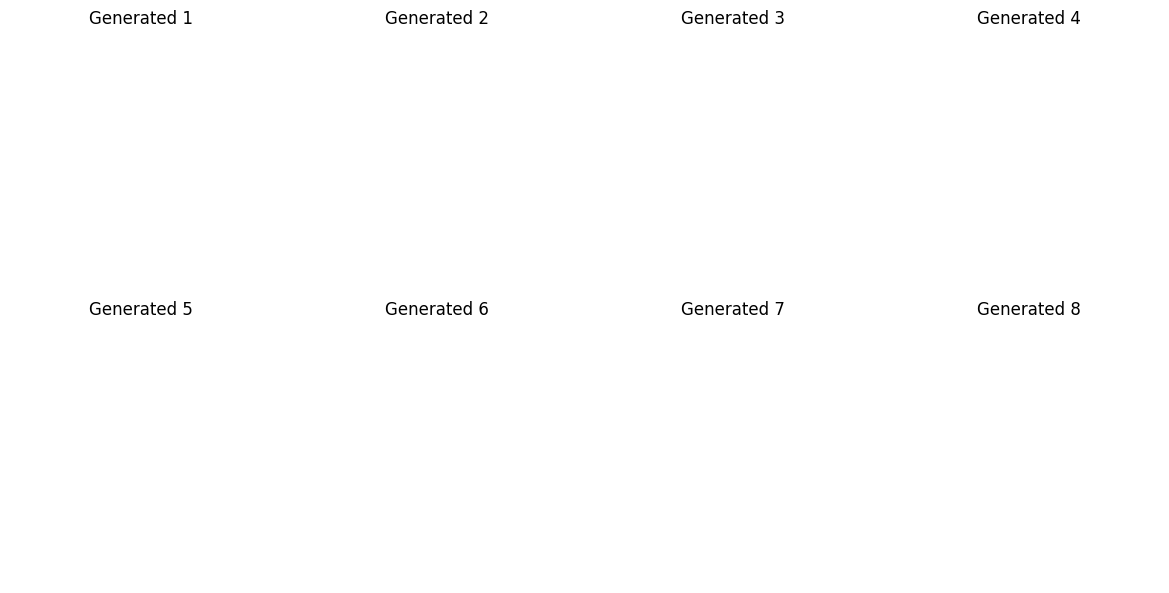

In [42]:
# Generate images
print("Generating images...")
generated = sample(model, (8, 1, 28, 28), device)

# Denormalize for visualization
generated = (generated + 1) / 2  # From [-1, 1] to [0, 1]
generated = torch.clamp(generated, 0, 1)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = generated[i].squeeze().cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Generated {i+1}')

plt.tight_layout()
plt.show()


## 8. Visualize Training Loss


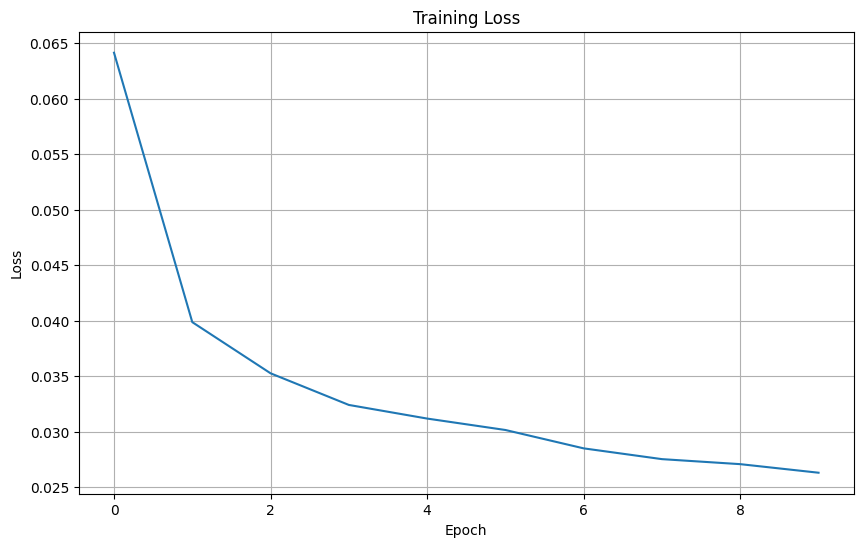

In [43]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


## 9. Visualize Forward Diffusion Process


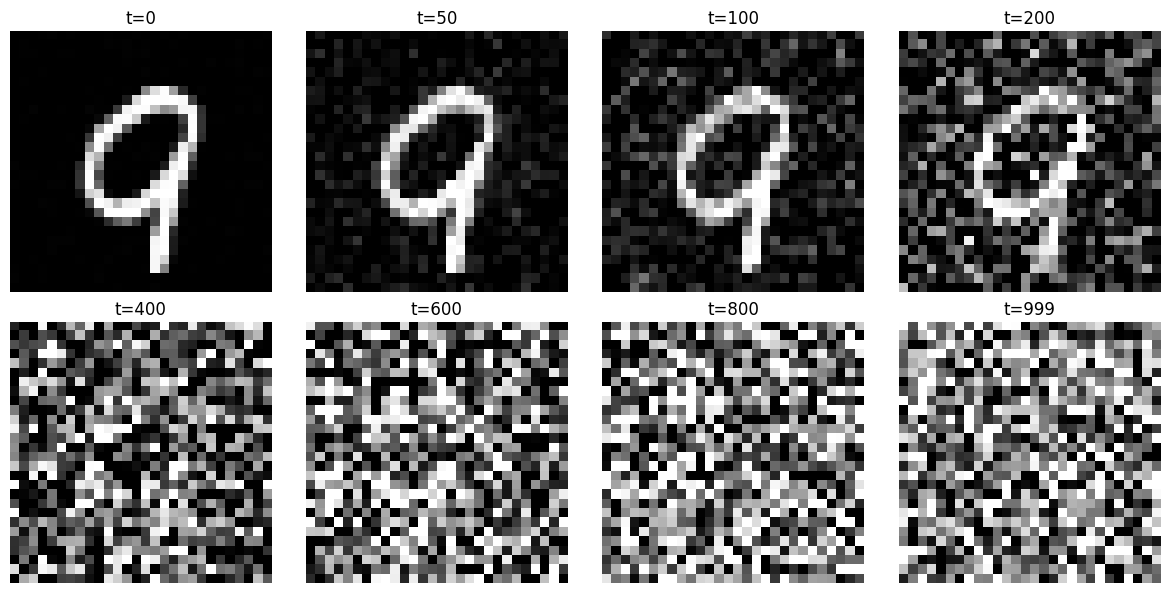

In [44]:
# Visualize how noise is added over time
test_image, _ = next(iter(loader))
test_image = test_image[0:1].to(device)

timesteps_to_show = [0, 50, 100, 200, 400, 600, 800, 999]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    noisy = q_sample(test_image, t_tensor)
    img = (noisy[0].squeeze().cpu().numpy() + 1) / 2
    img = np.clip(img, 0, 1)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f't={t}')

plt.tight_layout()
plt.show()


## Summary

You've successfully implemented a **Diffusion Model from scratch**! 

### What you built:
- ✅ **Noise schedule** (beta, alpha, alpha_bar)
- ✅ **Forward diffusion** (adding noise)
- ✅ **U-Net architecture** with time embeddings
- ✅ **Training loop** (noise prediction)
- ✅ **Sampling** (reverse diffusion for generation)

### Key Concepts:
- The model learns to **predict noise** at each timestep
- During generation, we **remove predicted noise** step by step
- This is the foundation of **Stable Diffusion** and other modern generative models!

### Next Steps:
- Train for more epochs for better quality
- Add self-attention layers
- Try on larger images (CIFAR-10, CelebA)
- Implement Latent Diffusion (VAE encoder/decoder)
